In [1]:
import torchaudio
from torch import Tensor
from IPython.display import Audio
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from helpers.path_utils import get_base_dir
from helpers.transform import TrimAfterTrigger, min_max_scale
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft

In [2]:
AUDIO_NAME = "SAM-Normal Heart Sounds 90 BPM.wav"

audio_dir = get_base_dir().joinpath("data", "mobile", "SAM", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

Sample rate:  22050


Sample rate:  4000


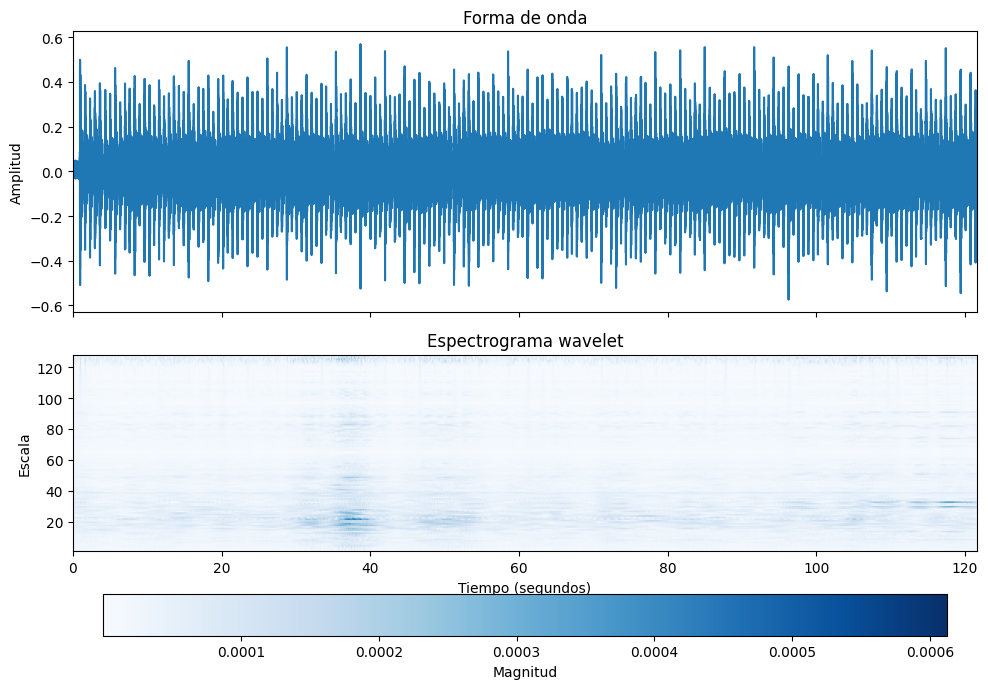

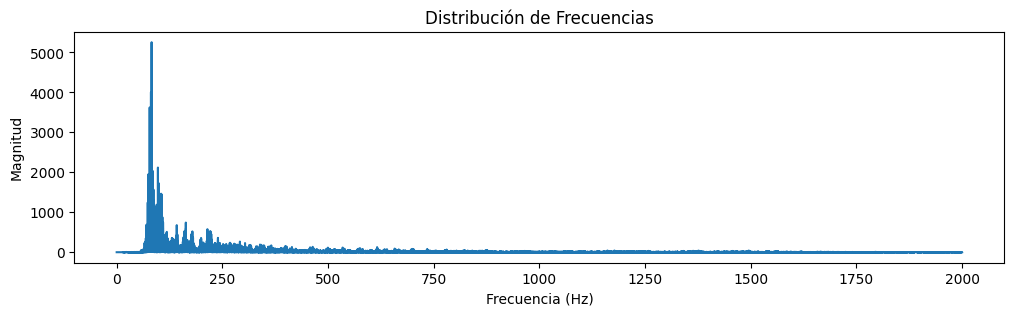

In [3]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(
    orig_freq=sample_rate, new_freq=new_sample_rate
)

audio = resampler(audio)
sample_rate = new_sample_rate

print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)  # , downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Snippet to detect hearbeats

In [4]:
SECS = 3
cut_on = SECS * sample_rate
snippet = audio[:, :cut_on].clone()
audio.shape, snippet.shape

(torch.Size([1, 486400]), torch.Size([1, 12000]))

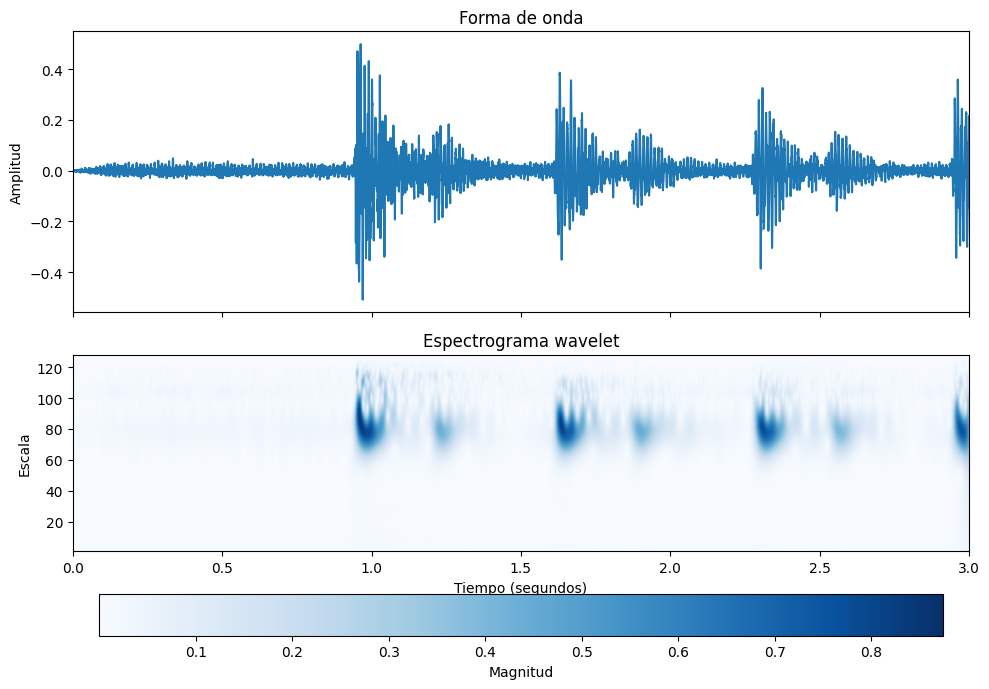

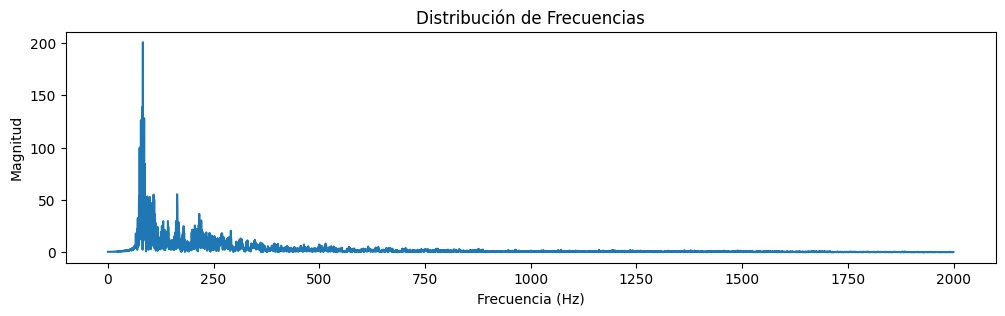

In [5]:
plot_wavelet_spectrogram(snippet, sample_rate, downsample_factor=1)
plot_audio_fft(snippet.numpy(), sample_rate)

Audio(snippet, rate=sample_rate, autoplay=True)

# TrimAfterTrigger class
We can use some methods of that class to detect heartbeats

In [6]:
tat = TrimAfterTrigger()
tat

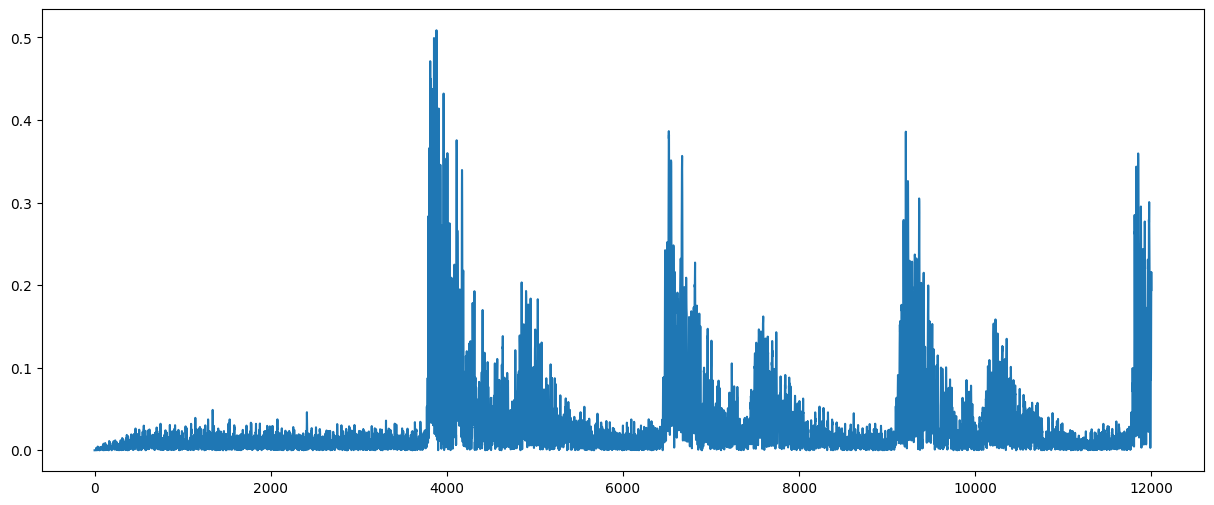

In [7]:
abs_snippet = tat.audio_to_abs(snippet)
plt.figure(figsize=(15, 6))
plt.plot(abs_snippet.squeeze())

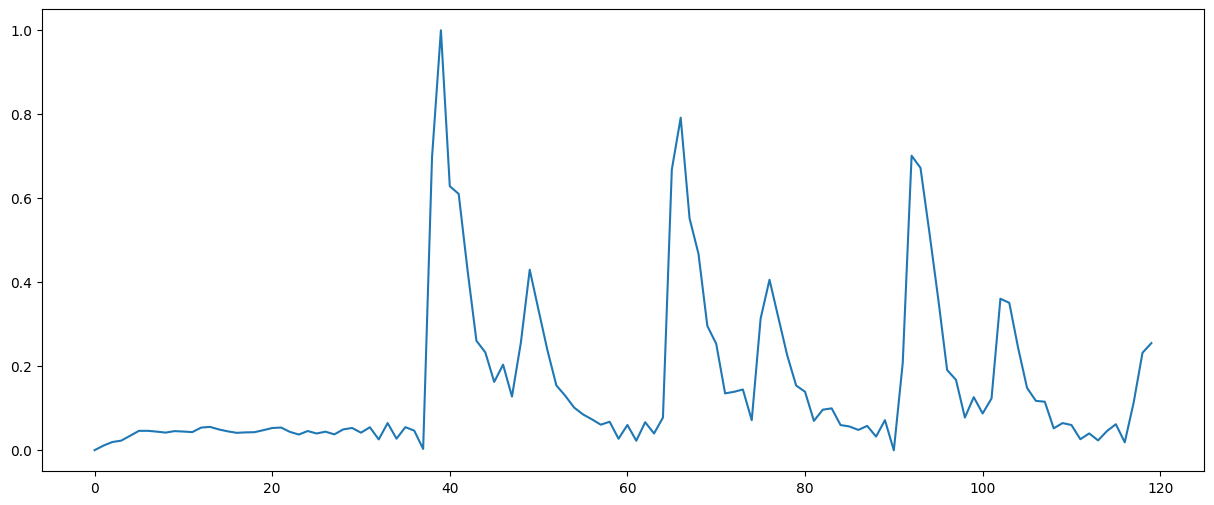

In [8]:
DOWNSAMPLE_FACTOR = 100
downsampled = tat.downsample_audio(abs_snippet, DOWNSAMPLE_FACTOR).copy()
scaled = tat.scale_audio(Tensor(downsampled), scaler=min_max_scale).squeeze()

plt.figure(figsize=(15, 6))
plt.plot(scaled.squeeze())

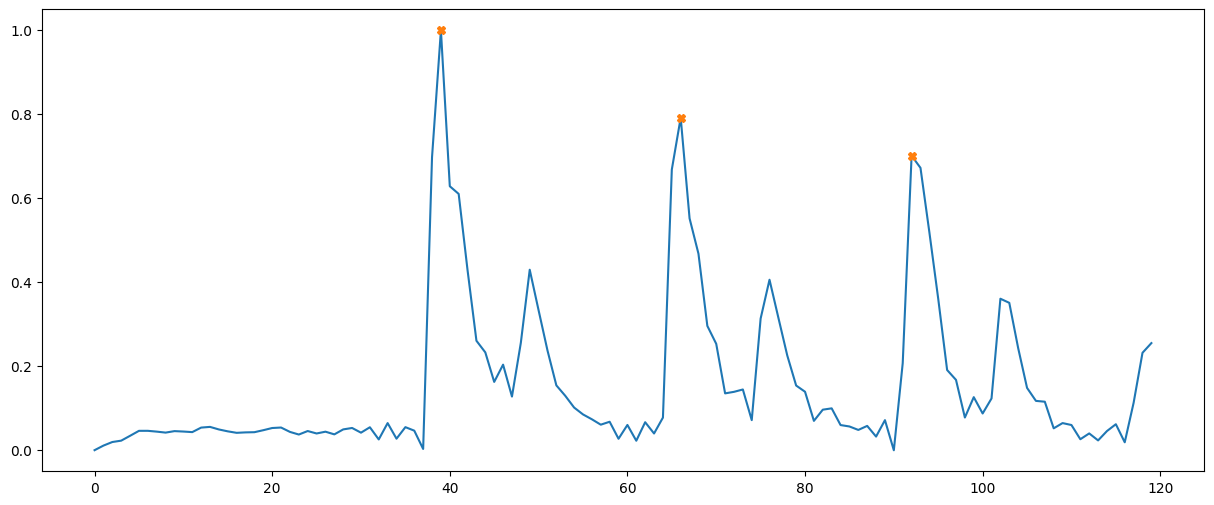

In [9]:
PEAKS_HEIGHT = 0.7
PEAKS_PROMINENCE = 0.0001

peaks, _ = find_peaks(scaled, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(scaled)
plt.plot(peaks, scaled[peaks], "X")

Peaks found in downsampled signal: [39 66 92]
Peaks in real signal: [3900 6600 9200]


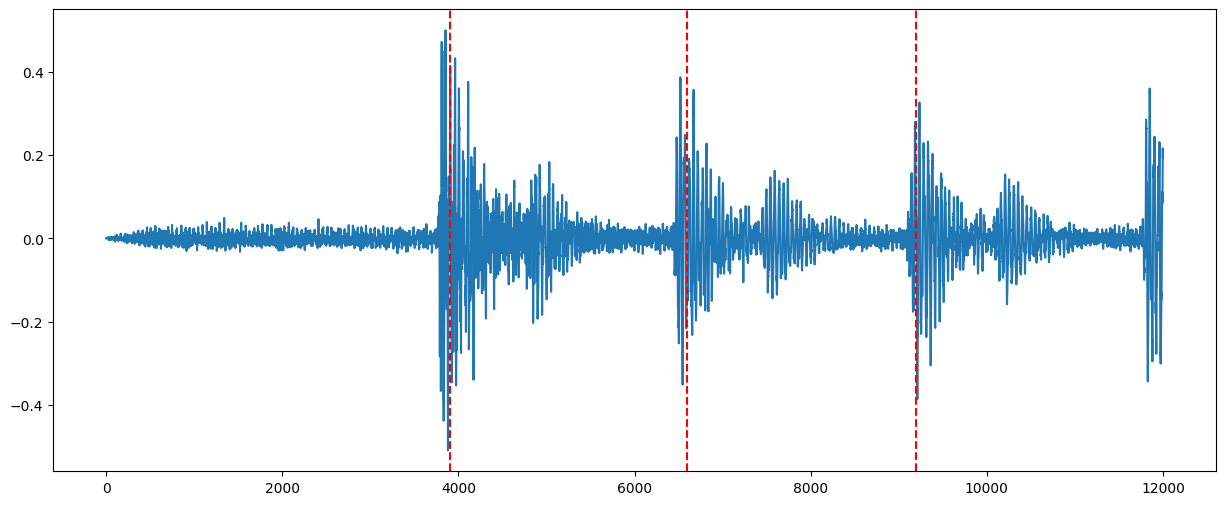

In [10]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(15, 6))
plt.plot(snippet.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()